In [1]:
NOTE = 'XGBoostベクトルは除外しPitcherIDでGroupKFold'
notebook_name = '085'
CV = 'GroupK-Fold(pitcherID)'
group_col = 'pitcherID'

In [2]:
import json
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [3]:
OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

# class_weights for CatBoostClassifier, copied from 020
CLASS_WEIGHTS = {
        0: 0.33822833,
        1: 0.4574968, 
        2: 0.71590909,
        3: 1.00280899,
        4: 3.17333333,
        5: 11.45454545,
        6: 194.72727273,
        7: 17.85
    }

085_submission.csv 085


In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
groups = train[group_col]

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

# categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
# discrete_features = list(set(minimal_features) - set(categorical_features))
# print(categorical_features)
# print(discrete_features)

# Execute if categories should be one-hot style
## categorical features
# for c in CATEGORICAL_FEATURES:
#     assert(train[c].isin(test[c]).sum() == train.shape[0])
#     assert(test[c].isin(train[c]).sum() == test.shape[0])
# train = pd.get_dummies(train, columns=CATEGORICAL_FEATURES, drop_first=True)
# test = pd.get_dummies(test, columns=CATEGORICAL_FEATURES, drop_first=True)
# assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
# assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())
# categorical_features = []
# for c in CATEGORICAL_FEATURES:
#     categorical_features += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
categorical_features = CATEGORICAL_FEATURES
## vector features
vector_features = VECTOR_FEATURES
## discrete features
discrete_features = [c for c in train.columns
                     if c not in ['y', 'id'] + vector_features + categorical_features]
## all features
features = categorical_features + discrete_features + vector_features

len(categorical_features), len(vector_features), len(discrete_features)

(12, 384, 107)

In [7]:
categorical_features

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [8]:
discrete_features

['totalPitchingCount',
 'B',
 'S',
 'O',
 'inningNo',
 'numRunners',
 'pitcherHoursElapsed',
 'pitcherNumGamesParticipated',
 'batterHoursElapsed',
 'batterNumGamesParticipated',
 'speedcount',
 'speedmean',
 'speedstd',
 'speedmin',
 'speed25%',
 'speed50%',
 'speed75%',
 'speedmax',
 'speedrange',
 'speedmeanDiff',
 'speedstdDiff',
 'speedminDiff',
 'speed25%Diff',
 'speed50%Diff',
 'speed75%Diff',
 'speedmaxDiff',
 'pitchTypeRatioカットファストボール',
 'pitchTypeRatioカーブ',
 'pitchTypeRatioシュート',
 'pitchTypeRatioシンカー',
 'pitchTypeRatioストレート',
 'pitchTypeRatioスライダー',
 'pitchTypeRatioチェンジアップ',
 'pitchTypeRatioフォーク',
 'battersFaced',
 'gameIDCount',
 'numInningsSum',
 'inningFromMin',
 'inningFromMean',
 'inningFromMedian',
 'inningFromMax',
 'inningFromStd',
 'inningToMin',
 'inningToMean',
 'inningToMedian',
 'inningToMax',
 'inningToStd',
 'pitcherNumStrikeOuts',
 'pitcherNumWalks',
 'hitsAllowed',
 'K/9',
 'BB/9',
 'K1p/BB1p',
 'whips',
 'pitchersFaced',
 'batterNumStrikeOuts',
 'batterNumWa

In [9]:
vector_features

['ballPositionLabel__no_data__',
 'ど真ん中',
 '内角中心',
 '内角低め',
 '内角高め',
 '外角中心',
 '外角低め',
 '外角高め',
 '真ん中低め',
 '真ん中高め',
 'ballPositionLabeld1',
 'ballPositionLabeld2',
 'ballPositionLabeld3',
 'ballPositionLabeld4',
 'ballPositionLabeld5',
 'ballPositionLabeld6',
 'ballPositionLabeld7',
 'ballPositionLabeld8',
 'ballPositionLabeld9',
 'ballPositionLabeld10',
 'ballPositionLabeld11',
 'ballPositionLabeld12',
 'ballPositionLabeld13',
 'ballPositionLabeld14',
 'ballPositionLabeld15',
 'ballPositionLabeld16',
 'ballPositionLabeld17',
 'ballPositionLabeld18',
 'ballPositionLabeld19',
 'ballPositionLabeld20',
 'ballPositionLabeld21',
 'ballPositionLabeld22',
 'ballPositionLabeld23',
 'ballPositionLabeld24',
 'ballPositionLabeld25',
 'ballPositionLabeld26',
 'ballPositionLabeld27',
 'ballPositionLabeld28',
 'ballPositionLabeld29',
 'ballPositionLabeld30',
 'ballPositionLabeld31',
 'ballPositionLabeld32',
 'ballPositionLabeld33',
 'ballPositionLabeld34',
 'ballPositionLabeld35',
 'ballPositionLabe

In [10]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [11]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [12]:
with open(os.path.join('001_EDA', f'group_kfold_{group_col}.json'), 'r') as f:
    fold = json.load(f)
fold

{'0': [120,
  478,
  504,
  607,
  587,
  107,
  136,
  447,
  363,
  2,
  618,
  593,
  616,
  597,
  407,
  48,
  58,
  4,
  394,
  49],
 '1': [311,
  305,
  269,
  143,
  224,
  182,
  267,
  55,
  156,
  550,
  371,
  336,
  575,
  158,
  400,
  211,
  647,
  222,
  493,
  528],
 '2': [130,
  651,
  298,
  448,
  387,
  405,
  634,
  438,
  102,
  245,
  507,
  190,
  147,
  520,
  169,
  210,
  409,
  595,
  494,
  630],
 '3': [247,
  128,
  282,
  185,
  657,
  288,
  459,
  45,
  419,
  16,
  434,
  579,
  596,
  435,
  81,
  334,
  181,
  6,
  467,
  635],
 '4': [348,
  373,
  191,
  101,
  116,
  59,
  383,
  517,
  506,
  350,
  376,
  460,
  35,
  97,
  650,
  119,
  662,
  10,
  359],
 '5': [542,
  241,
  155,
  218,
  196,
  82,
  532,
  524,
  31,
  294,
  110,
  578,
  137,
  476,
  358,
  552,
  262,
  553],
 '6': [483,
  519,
  377,
  395,
  481,
  -1,
  146,
  563,
  29,
  25,
  539,
  114,
  522,
  501,
  474,
  440,
  351,
  275],
 '7': [629,
  365,
  640,
  623,
  

In [13]:
%%time
# splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
# for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
for str_i, ids in fold.items():
    i = int(str_i)
    mask = groups.isin(ids)  # training/validation = False/True
    train_idx, id_train, X_train, y_train, valid_idx, id_valid, X_valid, y_valid = (
        train[~mask].index,
        train[~mask].id,
        train[~mask][features],
        train[~mask].y,
        train[mask].index,
        train[mask].id,
        train[mask][features],
        train[mask].y,
    )
    # feature transformation
    ## categorical features
    """
    X_train_categorical = X_train.copy()[categorical_features]
    X_valid_categorical = X_valid.copy()[categorical_features]
    X_test_categorical = test.copy()[categorical_features]
    """
    ## descrete features
    """
    discrete_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    ).fit(X_train.copy()[discrete_features])
    X_train_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_train.copy()[discrete_features]),
        columns=discrete_features,
        index=train_idx
    )
    X_valid_discrete = pd.DataFrame(
        data=discrete_transformer.transform(X_valid.copy()[discrete_features]),
        columns=discrete_features,
        index=valid_idx
    )
    X_test_discrete = pd.DataFrame(
        data=discrete_transformer.transform(test.copy()[discrete_features]),
        columns=discrete_features,
        index=test.index
    )
    discrete_transformer.feature_names__ = discrete_features
    discrete_transformer.input_features__ = discrete_features
    with open(os.path.join(OUTPUT_DIR, f'discrete_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(discrete_transformer, f)
        f.close()
    """
    ## vector features
    """
    vector_transformer = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler()),
            ('decomposer', PCA(n_components=0.8, whiten=True, random_state=SEED))
        ]
    ).fit(X_train.copy()[vector_features])
    columns = [f'pca{i + 1}' for i in range(vector_transformer[-1].n_components_)]
    X_train_vector = pd.DataFrame(
        data=vector_transformer.transform(X_train.copy()[vector_features]),
        columns=columns,
        index=train_idx
    )
    X_valid_vector = pd.DataFrame(
        data=vector_transformer.transform(X_valid.copy()[vector_features]),
        columns=columns,
        index=valid_idx
    )
    X_test_vector = pd.DataFrame(
        data=vector_transformer.transform(test.copy()[vector_features]),
        columns=columns,
        index=test.index
    )
    vector_transformer.feature_names__ = vector_features
    vector_transformer.input_features__ = vector_features
    with open(os.path.join(OUTPUT_DIR, f'vector_transformer_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(vector_transformer, f)
        f.close()
    """
    ## merge
    X_train_transformed = X_train[discrete_features + categorical_features]
    X_train_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'train_features_fold{i + 1}.zip'),
        protocol=-1
    )

    X_valid_transformed = X_valid[discrete_features + categorical_features]
    X_valid_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'valid_features_fold{i + 1}.zip'),
        protocol=-1
    )
    X_test_transformed = test[discrete_features + categorical_features]
    X_test_transformed.to_pickle(
        os.path.join(OUTPUT_DIR, f'test_features_fold{i + 1}.zip'),
        protocol=-1
    )
    class_weight = compute_class_weight('balanced',
                                        classes=np.sort(train.y.unique()),
                                        y=y_train.values)
    class_weight = dict(
        zip(
            np.sort(train.y.unique()),
            class_weight
        )
    )
    sample_weight = y_train.map(class_weight)
    assert(sample_weight.isnull().sum() == 0)
#     sample_weight = None
    # classification    
    clf = XGBClassifier(n_jobs=-1,
                        n_estimators=500,
                        learning_rate=0.01,
                        random_state=SEED)
    clf.fit(X_train_transformed,
            y_train.values,
            sample_weight=sample_weight)
    clf.feature_names__ = X_train_transformed.columns.tolist()
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(clf, f)
        f.close()
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train_transformed)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid_transformed)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 1
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(X_test_transformed)
    except AttributeError:
        infer = clf.decision_function(X_test_transformed)
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf.classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)


C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:05:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 1)**********
[[1900 1203  607  702  501  397   27  341]
 [ 474 2127  358  399  314  241   22  225]
 [ 286  391  952  385  289  192   10  151]
 [ 180  204  118 1081  137   94   12   79]
 [  29   30   27   30  443   28    1   25]
 [   0    0    0    0    0  170    0    2]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  104]]

**********Confusion matrix for validation set (Fold 1)**********
[[173 186  49 125  65  16   1  40]
 [104 218  42  76  28  17   2  35]
 [ 50  67  43  93  33  19   2  29]
 [ 48  44  22  73  21   6   1  16]
 [  8  14   3  22  10   0   0   5]
 [  4   1   3   4   3   0   0   0]
 [  1   0   0   0   0   0   0   0]
 [  1   5   0   3   2   2   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:06:31] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 2)**********
[[1947 1140  606  584  478  392   38  368]
 [ 497 2083  349  359  317  233   27  242]
 [ 307  363  917  372  301  191   13  163]
 [ 195  222  129  986  138   89   11   91]
 [  20   30   15   30  438   29    2   24]
 [   0    0    0    1    0  166    0    1]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 2)**********
[[224 218  53 140  83  39   1  22]
 [111 250  31  88  40  29   4  22]
 [ 63  68  37 103  52  20   1  21]
 [ 42  46  23  88  47  16   1  12]
 [ 12  13   7  24  17  10   0   4]
 [  1   4   0   6   3   2   0   3]
 [  0   0   1   0   0   0   0   0]
 [  3   2   1   2   0   2   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:07:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 3)**********
[[2043 1106  628  581  488  392   42  391]
 [ 500 2059  353  353  316  240   34  266]
 [ 297  373  934  358  284  180   20  172]
 [ 147  221  148 1020  136  104   15   86]
 [  18   31   19   22  441   27    3   32]
 [   1    1    0    0    1  154    0    6]
 [   0    0    0    0    0    0    9    0]
 [   0    0    0    0    0    0    0  108]]

**********Confusion matrix for validation set (Fold 3)**********
[[189 186  68 105  59  23   8  24]
 [ 96 245  47  91  44  17   4  17]
 [ 72  73  46 104  49  10   1  19]
 [ 39  55  29  86  27  12   3   8]
 [ 14  12  14  14  15   7   1   5]
 [  0   6   4   7   3   2   1   1]
 [  1   1   0   0   0   0   0   0]
 [  2   5   1   1   1   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:03] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 4)**********
[[1976 1136  667  598  460  408   36  386]
 [ 512 2133  368  374  274  260   29  260]
 [ 298  375  956  384  287  173   10  180]
 [ 173  215  135 1071  134   97   10   83]
 [  24   39   14   38  436   30    2   23]
 [   0    0    1    0    0  153    0    2]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  106]]

**********Confusion matrix for validation set (Fold 4)**********
[[179 163  47 109  71  31   2  64]
 [ 90 174  25  70  44  22   3  44]
 [ 46  61  36  84  50  20   1  31]
 [ 35  36  22  64  33   8   1  19]
 [ 15  10   8   8  15   4   0   9]
 [  5   4   1   6   6   4   0   5]
 [  1   0   0   0   0   0   0   0]
 [  2   1   1   2   3   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:08:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 5)**********
[[1990 1202  610  674  477  349   31  409]
 [ 534 2153  339  391  300  231   31  297]
 [ 313  394  984  396  287  187   12  171]
 [ 181  220  124 1078  138   96   12   95]
 [  28   36   18   30  446   28    4   30]
 [   1    1    1    0    1  162    0    4]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

**********Confusion matrix for validation set (Fold 5)**********
[[150 189  47  74  53  25  12  41]
 [ 54 185  23  55  33  16   4  36]
 [ 36  63  30  55  35  10   2  17]
 [ 30  36  30  55  15   9   3  14]
 [ 12   8   8   9   7   2   0   9]
 [  3   2   2   1   5   2   1   1]
 [  0   0   0   1   0   0   0   0]
 [  1   1   0   1   4   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:09:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 6)**********
[[2145 1079  604  583  479  376   18  384]
 [ 583 2061  359  366  310  244   20  263]
 [ 316  379  978  364  278  170    8  192]
 [ 192  214  155 1012  158   87    8  101]
 [  19   33   22   22  453   28    2   21]
 [   0    0    1    0    1  163    0    1]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

**********Confusion matrix for validation set (Fold 6)**********
[[185 196  56  90  83  26   4  25]
 [100 192  41  50  47  19   3  24]
 [ 60  74  35  69  49  13   0   7]
 [ 31  42  24  77  21   6   2   6]
 [ 14   9   7  19  17   2   0   7]
 [  4   5   1   2   4   2   0   3]
 [  0   0   0   0   1   0   0   0]
 [  1   4   0   2   3   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:10:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 7)**********
[[2003 1146  565  621  472  364   37  377]
 [ 520 2099  352  346  285  213   32  263]
 [ 341  397  902  397  262  181   11  173]
 [ 170  222  136 1021  127   89   13   96]
 [  35   32   23   23  425   31    2   33]
 [   0    0    0    0    1  167    0    3]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 7)**********
[[225 188  51 161  27  49   3  44]
 [136 216  32 112  25  29   4  18]
 [ 77  48  40  96  19  21   2  25]
 [ 59  45  20  90  20  11   0  17]
 [ 22   5   6  13   8  10   1   6]
 [  4   4   2   2   0   2   0   2]
 [  1   0   0   0   0   0   0   0]
 [  6   0   0   4   0   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 8)**********
[[2045 1110  617  617  477  377   45  408]
 [ 554 2119  343  369  300  237   45  286]
 [ 324  385  902  401  290  187   16  199]
 [ 184  236  145 1022  134   95   15  112]
 [  24   30   18   22  428   31    3   37]
 [   0    0    0    0    0  164    0    5]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  107]]

**********Confusion matrix for validation set (Fold 8)**********
[[205 168  59  45  57  43   3  57]
 [106 169  25  28  33  29   3  36]
 [ 62  63  29  38  39  28   1  28]
 [ 47  29  16  37  36  11   1  16]
 [ 12  16  12   8  20   9   0   5]
 [  5   2   1   0   4   3   0   3]
 [  0   0   1   0   0   0   0   0]
 [  3   6   0   1   1   0   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 9)**********
[[2007 1188  647  633  504  414   31  396]
 [ 515 2220  367  360  311  253   33  271]
 [ 303  430  936  411  306  199   12  176]
 [ 187  250  139 1052  149   96   10   98]
 [  31   39   21   32  437   31    4   28]
 [   0    0    0    1    1  169    0    4]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  110]]

**********Confusion matrix for validation set (Fold 9)**********
[[160 134  42  45  42  32   0  58]
 [ 91 137  27  39  21   9   0  28]
 [ 59  28  27  35  32  16   0  22]
 [ 39  26  13  48  12  10   0   7]
 [  9   6   7  10  14   3   0   3]
 [  3   4   0   1   3   1   0   0]
 [  0   1   0   0   0   0   0   0]
 [  1   1   0   1   5   1   0  

C:\Users\nndropout\miniconda3\envs\ds\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:12:41] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
**********Confusion matrix for train set (Fold 10)**********
[[1967 1267  698  646  509  382   20  428]
 [ 531 2232  368  373  320  238   21  282]
 [ 309  435  981  401  286  184    8  190]
 [ 188  228  158 1072  147  103    7   91]
 [  33   35   19   31  455   32    1   29]
 [   0    1    0    0    0  172    0    0]
 [   0    0    0    0    0    0   10    0]
 [   0    0    0    0    0    0    0  111]]

**********Confusion matrix for validation set (Fold 10)**********
[[128  97  31  67  41  10   0  42]
 [ 47 126  33  40  35   7   0  29]
 [ 40  26  24  62  28   4   0  14]
 [ 17  25  17  50  16   2   0  15]
 [  7   4   3   7  12   3   0   4]
 [  3   4   2   1   2   0   0   2]
 [  0   1   0   0   0   0   0   0]
 [  1   4   0   1   1   0   0

In [14]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,10.000000,10.000000
mean,0.359697,0.168018
std,0.007139,0.005060
min,0.348422,0.160050
25%,0.354946,0.164877
50%,0.359670,0.166409
75%,0.363698,0.170866
max,0.373696,0.175753


In [15]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,1,0,1
2,2,0,4,0,1
3,3,2,2,0,1
4,4,4,4,0,1
...,...,...,...,...,...
17075,1431,1,1,1,10
17076,1432,0,0,1,10
17077,1433,1,3,1,10
17078,1434,2,3,1,10


In [16]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,0.087489,0.147441,0.238144,0.181912,0.258020,0.046809,0.012727,0.027458,27446,1
1,0.124344,0.105405,0.250821,0.248553,0.185099,0.058323,0.010176,0.017279,113,1
2,0.176148,0.416557,0.213321,0.093670,0.049221,0.035996,0.006281,0.008807,4479,1
3,0.171407,0.278167,0.234364,0.180634,0.079412,0.036165,0.006822,0.013028,29080,1
4,0.142753,0.085702,0.146415,0.094457,0.119311,0.388691,0.007296,0.015375,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,0.122985,0.550984,0.176244,0.099732,0.009959,0.021588,0.009218,0.009290,24272,10
33804,0.120350,0.332446,0.325550,0.162129,0.012610,0.023550,0.011638,0.011728,29106,10
33805,0.105610,0.290139,0.399781,0.151273,0.012426,0.017745,0.011468,0.011557,20679,10
33806,0.262970,0.264988,0.288468,0.126752,0.011176,0.024936,0.010314,0.010395,25901,10


In [17]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,1.140317,2.450131,2.144348,1.823859,1.965603,0.278872,0.097940,0.098929
1,1,2.724902,3.121779,1.251649,1.136148,0.293066,1.178241,0.083733,0.210481
2,2,0.264502,1.070714,1.695287,5.213288,0.966191,0.319690,0.111918,0.358410
3,3,2.298210,2.544378,1.516438,2.222173,0.810920,0.422077,0.092413,0.093392
4,4,3.319366,2.657354,0.974632,1.081214,1.353290,0.324357,0.079205,0.210583
...,...,...,...,...,...,...,...,...,...
33803,33803,3.352825,0.876336,0.990550,0.936062,1.997028,1.156094,0.089470,0.601636
33804,33804,2.243391,2.472958,1.245476,2.726885,0.341838,0.699556,0.082691,0.187205
33805,33805,2.568837,2.718434,1.172671,2.204878,0.457713,0.648831,0.065285,0.163350
33806,33806,1.279260,1.827027,2.900754,3.162614,0.192505,0.331349,0.152483,0.154008


In [18]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,3
3,3,1
4,4,0
...,...,...
33803,33803,0
33804,33804,3
33805,33805,1
33806,33806,3


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.173864
1    0.465304
2    0.058655
3    0.186968
4    0.054040
5    0.020143
6    0.003697
7    0.037328
Name: y, dtype: float64

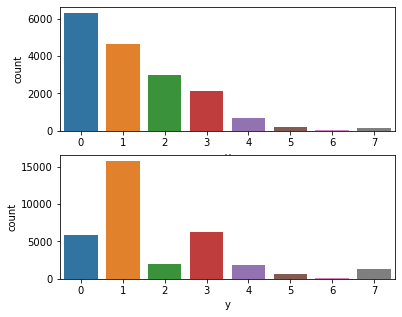

In [19]:
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [20]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [21]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.3596967170876416, 0.1680181221742091)

In [22]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"085_submission.csv","GroupK-Fold(pitcherID)","0.359697","0.168018","","XGBoostベクトルは除外しPitcherIDでGroupKFold"


In [23]:
%%time
imp_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 32.7 s


In [24]:
imp_df

,feature,importance,fold
0,totalPitchingCount,0.005364,1
1,B,0.008586,1
2,S,0.011324,1
3,O,0.010154,1
4,inningNo,0.007078,1
...,...,...,...
114,batterTeam,0.003402,10
115,pitcherTeam,0.004522,10
116,b1,0.007090,10
117,b2,0.003911,10


In [25]:
%%time
coef_df = pd.DataFrame()
for i, final_estimator in enumerate(models):
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=final_estimator.feature_names__)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 0 ns


In [26]:
coef_df

""
